In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def decibels_to_gain(x):
    if x > float("-inf"):
        return 10 ** (x / 20)
    return 0

In [11]:
import math

def gain_to_decibels(x):
    if x > 0:
        return math.log10(x) * 20
    return float("-inf")

In [12]:
threshold = -20
ratio = 4
knee = 6
FS = 48000

In [13]:
def get_gain_reduction(env):
    lower_knee_bound = threshold - (knee / 2)
    upper_knee_bound = threshold + (knee / 2)
    gain_reduction = 1 - (1 / ratio)
    if env <= lower_knee_bound:
        return 0
    elif env <= upper_knee_bound:
        gain_reduction *= ((env - lower_knee_bound) / knee) / 2
        return gain_reduction * (lower_knee_bound - env)
    else:
        return gain_reduction * (threshold - env)

In [14]:
def process_sample(sample):
    env = gain_to_decibels(abs(sample))
    gain = get_gain_reduction(env)
    return sample * decibels_to_gain(gain)

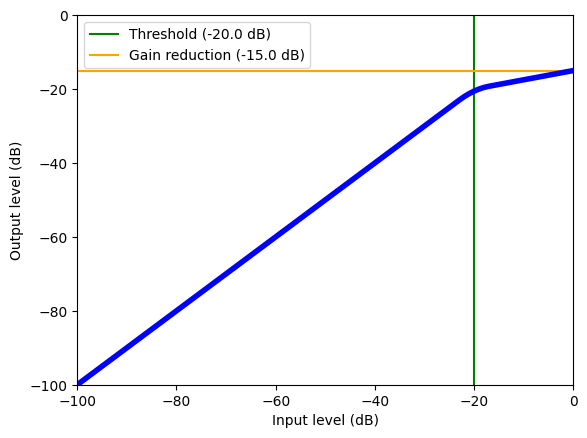

In [15]:
%matplotlib inline

x = np.linspace(-100,0,101)
y = np.array([gain_to_decibels(process_sample(decibels_to_gain(i))) for i in x])
plt.xlim(-100, 0)
plt.ylim(-100, 0)
plt.plot([threshold, threshold], [-100, 0], color="green", label=f"Threshold ({threshold:.1f} dB)")
plt.plot([-100, 0], [get_gain_reduction(0), get_gain_reduction(0)], color="orange", label=f"Gain reduction ({get_gain_reduction(0):.1f} dB)")
plt.plot(x, y, color="blue", linewidth=4)
plt.ylabel("Output level (dB)")
plt.xlabel("Input level (dB)")
plt.legend()
plt.show()

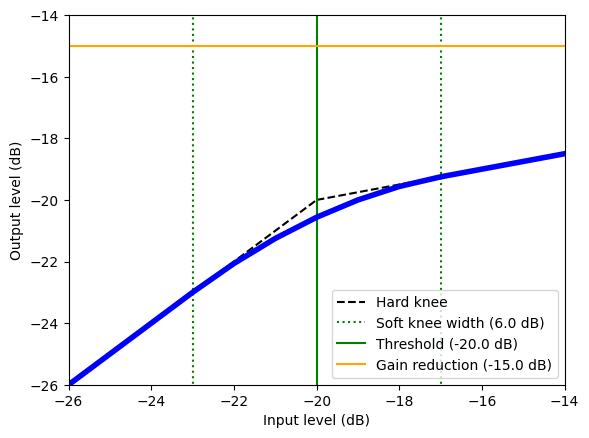

In [16]:
%matplotlib inline

x = np.linspace(-100,0,101)
y = np.array([gain_to_decibels(process_sample(decibels_to_gain(i))) for i in x])
plt.xlim(threshold - knee, threshold + knee)
plt.ylim(threshold - knee, threshold + knee)
plt.plot([-100, threshold], [-100, threshold], "--", color="black", label="Hard knee")
plt.plot([threshold, 0], [threshold * (1 / ratio) + get_gain_reduction(0), get_gain_reduction(0)], "--", color="black")
plt.plot([threshold - knee / 2, threshold - knee / 2], [-100, 0], ":", color="green", label=f"Soft knee width ({knee:.1f} dB)")
plt.plot([threshold + knee / 2, threshold + knee / 2], [-100, 0], ":", color="green")
plt.plot([threshold, threshold], [-100, 0], color="green", label=f"Threshold ({threshold:.1f} dB)")
plt.plot([-100, 0], [get_gain_reduction(0), get_gain_reduction(0)], color="orange", label=f"Gain reduction ({get_gain_reduction(0):.1f} dB)")
plt.plot(x, y, color="blue", linewidth=4)
plt.ylabel("Output level (dB)")
plt.xlabel("Input level (dB)")
plt.legend()
plt.show()

In [17]:
class EnvelopeDetector:
    
    def __init__(self, attack, release, rms=False):
        self.attack = attack
        self.release = release
        self.rms = rms
        self.attack_coeff = math.exp(math.log(0.368) / (attack * FS))
        self.release_coeff = math.exp(math.log(0.368) / (release * FS))
        self.envelope = 0
    
    def get_envelope(self, y):
        y = abs(y)
        if self.rms:
            y *= y
        if y > self.envelope:
            envelope = self.attack_coeff * (self.envelope - y) + y
        else:
            envelope = self.release_coeff * (self.envelope - y) + y
        envelope = min(envelope, 1.0)
        envelope = max(envelope, 0.0)
        self.envelope = envelope
        if self.rms:
            envelope **= 0.5
        return envelope

In [18]:
def generate_signal(frequency, amplitude, duration):
    x = np.linspace(0.0, duration, int(duration * FS), endpoint=False)
    y = np.sin(2 * np.pi * x * frequency)
    return y * decibels_to_gain(amplitude)

In [24]:
f1, f2, f3 = 1.0, 1.0, 1.0
a1, a2, a3 = threshold - knee / 2, -0, threshold - knee / 2
d1, d2, d3 = 2.0, 4.0, 8.0
y = np.concatenate([
    generate_signal(f1, a1, d1),
    generate_signal(f2, a2, d2),
    generate_signal(f3, a3, d3),
])
x = np.linspace(0.0, len(y), len(y))

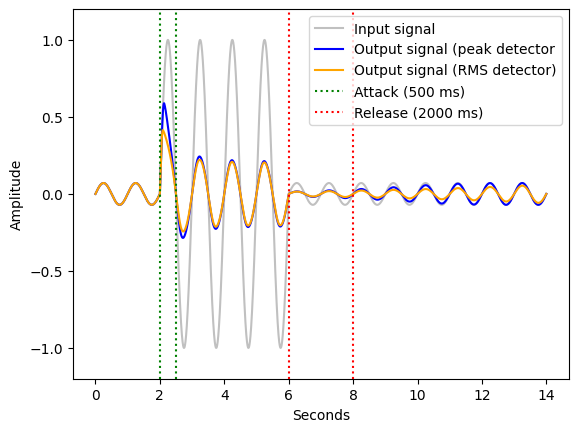

In [27]:
plt.plot(x / FS, y, color="silver", label="Input signal")

env = EnvelopeDetector(attack=0.5, release=2.0, rms=False)
ys = [i * decibels_to_gain(get_gain_reduction(gain_to_decibels(env.get_envelope(i)))) for i in y]
plt.plot(x / FS, ys, color="blue", label="Output signal (peak detector")

env = EnvelopeDetector(attack=0.5, release=2.0, rms=True)
ys = [i * decibels_to_gain(get_gain_reduction(gain_to_decibels(env.get_envelope(i)))) for i in y]
plt.plot(x / FS, ys, color="orange", label="Output signal (RMS detector)")

plt.plot([d1, d1], [-1.2, 1.2], ":", color="green")
plt.plot([d1 + env.attack, d1 + env.attack], [-1.2, 1.2], ":", color="green", label=f"Attack ({env.attack * 1000:.0f} ms)")
plt.plot([d1 + d2, d1 + d2], [-1.2, 1.2], ":", color="red")
plt.plot([d1 + d2 + env.release, d1 + d2 + env.release], [-1.2, 1.2], ":", color="red", label=f"Release ({env.release * 1000:.0f} ms)")
plt.ylim(-1.2, 1.2)
plt.xlabel("Seconds")
plt.ylabel("Amplitude")
plt.legend()

plt.show()